<h1><center>Clustering</center></h1>
<h2><center>Universidad Nacional de Colombia</center></h2>
<h2><center>Técnicas de inteligencia artificial</center></h2>
<h2><center>Camilo Esteban Zambrano Pereira</center></h2>

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
import cv2
from scipy.cluster import vq
from numpy import random
from scipy.spatial.distance import pdist, squareform
import itertools

# Funciones de visualización
---

In [2]:
# Gráfica de la varianza explicada acumulada.
def cumulative_explained_variance_plot(expl_variance):
    cum_var_exp = np.cumsum(expl_variance)
    plt.figure(dpi = 100, figsize = (8, 6))
    plt.title('Curva acumulativa de la varianza explicada VS n° de componentes principales', 
            fontdict= dict(family ='serif', size = 16))
    plt.xlabel('Número de componentes principales',
             fontdict= dict(family ='serif', size = 14))
    plt.ylabel('Varianza explicada acumulativa',
             fontdict= dict(family ='serif', size = 14))  
    nc = np.arange(1, expl_variance.shape[0] + 1)
    plt.plot(nc, cum_var_exp, '--r')
    plt.plot(nc, cum_var_exp, 'b.', ms = 5)   
    plt.show()

In [3]:
# Gracicar la curva de aprendizaje de determinada métrica de agrupamiento.

def plot_metric(K, scores, metric_name):
    plt.figure(dpi=110, figsize=(9, 5))
    plt.plot(K, scores, 'bx-')
    plt.xticks(K); plt.xlabel('$k$', fontdict=dict(family = 'serif', size = 14));  plt.ylabel(metric_name, fontdict=dict(family = 'serif', size = 14));
    plt.title(f'K vs {metric_name}', fontdict=dict(family = 'serif', size = 18))
    plt.show()

# Carga de datos
---

Los datos son obtenidos de la capa de flatten de una red convolucional, convierte 64 imágenes de 14px x 14px en un arreglo de 12544 valores más su etiqueta. Dataset no adjunto por su peso (~300 mb).

In [131]:
df = pd.read_csv("flatten.csv")
df = df.drop("Unnamed: 0", axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,12535,12536,12537,12538,12539,12540,12541,12542,12543,type
0,0.0,0.000000,1.415374,0.0,0.0,0.0,0.0,0.0,0.000000,8.265763,...,0.0,1.553692,22.458690,0.000000,0.0,0.0,0.0,0.0,4.799305,normal
1,0.0,0.000000,1.087682,0.0,0.0,0.0,0.0,0.0,0.000000,6.083829,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,13.024460,normal
2,0.0,0.006299,1.122064,0.0,0.0,0.0,0.0,0.0,0.003585,2.599781,...,0.0,0.049628,0.013092,0.043446,0.0,0.0,0.0,0.0,0.000000,normal
3,0.0,0.000000,1.531032,0.0,0.0,0.0,0.0,0.0,0.000000,8.260730,...,0.0,1.326889,16.620764,0.000000,0.0,0.0,0.0,0.0,5.554630,normal
4,0.0,0.003151,1.000326,0.0,0.0,0.0,0.0,0.0,0.000000,3.118132,...,0.0,0.935073,17.111837,0.000000,0.0,0.0,0.0,0.0,4.875857,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,0.0,0.000000,0.742261,0.0,0.0,0.0,0.0,0.0,0.000000,8.096829,...,0.0,1.197838,0.342678,0.597430,0.0,0.0,0.0,0.0,2.007606,tumor
4596,0.0,0.003075,1.080402,0.0,0.0,0.0,0.0,0.0,0.000000,2.956149,...,0.0,0.998440,13.452873,0.000000,0.0,0.0,0.0,0.0,6.844882,tumor
4597,0.0,0.000000,0.602449,0.0,0.0,0.0,0.0,0.0,0.000000,9.698757,...,0.0,1.716627,10.341248,0.912831,0.0,0.0,0.0,0.0,4.138659,tumor
4598,0.0,0.000000,1.192817,0.0,0.0,0.0,0.0,0.0,0.000000,8.425463,...,0.0,0.000000,22.042240,0.000000,0.0,0.0,0.0,0.0,2.276683,tumor


In [16]:
y = df["type"]
X = df.drop("type", axis=1)

## Imágenes en la primera fila
---

Ejemplo del conjunto de 64 imágenes para la primera fila del dataset:

In [111]:
images_1 = np.reshape(np.array(X.iloc[1]), (14, 14, 64))

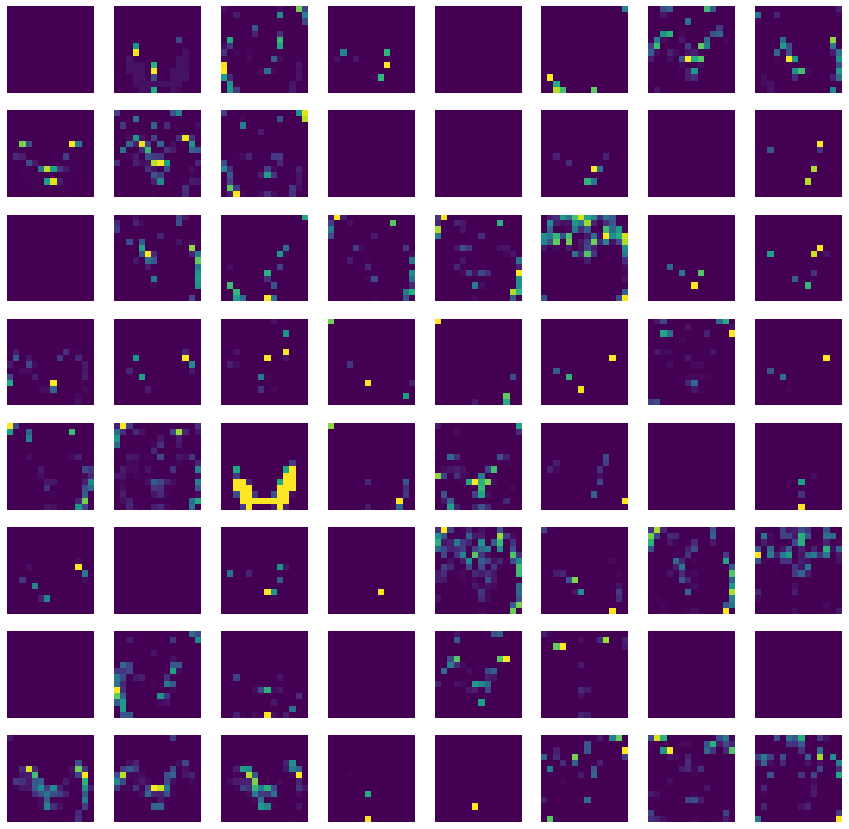

In [125]:
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
for filter_i in range(64):
    ax[filter_i//8, filter_i%8].imshow(images_1[:, :, filter_i])
    ax[filter_i//8, filter_i%8].axis("off")

# PCA
---

Dado las dimensiones del dataset, es necesario aplicar PCA

In [17]:
pca = PCA() 
pca_trans = pca.fit_transform(X)
varianza_expl = pca.explained_variance_ratio_
varianza = pca.explained_variance_

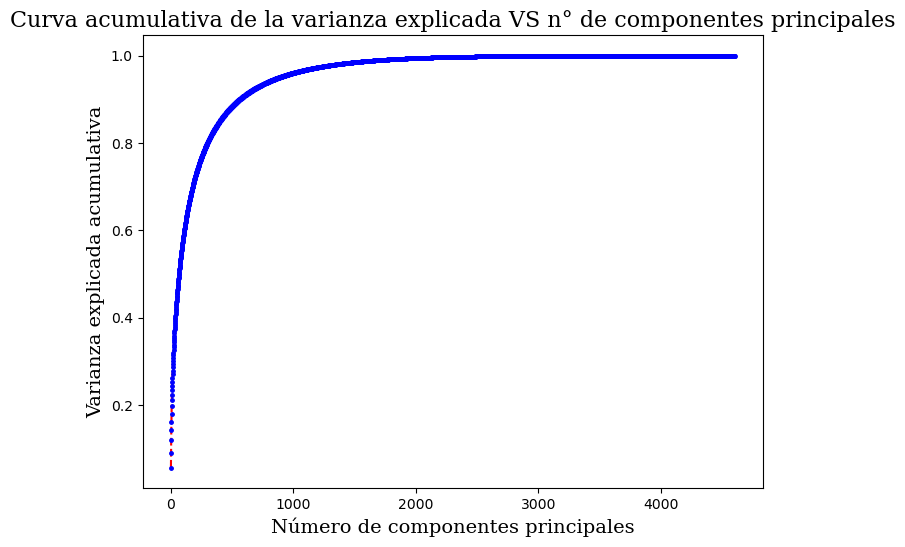

In [18]:
cumulative_explained_variance_plot(varianza_expl)

Se establece el número adecuado de componentes (>99%)

In [19]:
cum_var_exp = np.cumsum(varianza_expl)
n_components = np.where(cum_var_exp > 0.99)[0][0]
n_components

1689

In [20]:
pca = PCA(n_components = n_components) 
X_trans = pca.fit_transform(X)

# K-Means
---

Tomando los datos se aplica K-Means con diferente número de clusters. Se calcula la inercia inter clusters para identificar por la regla del codo una cantidad apropiada de K. Se observa que un valor apropiado podría ser 8. Esto tiene algo de sentido ya que las imagenes tienen 4 posiciones de la cabeza con 2 clases cada uno (cancer o sano).

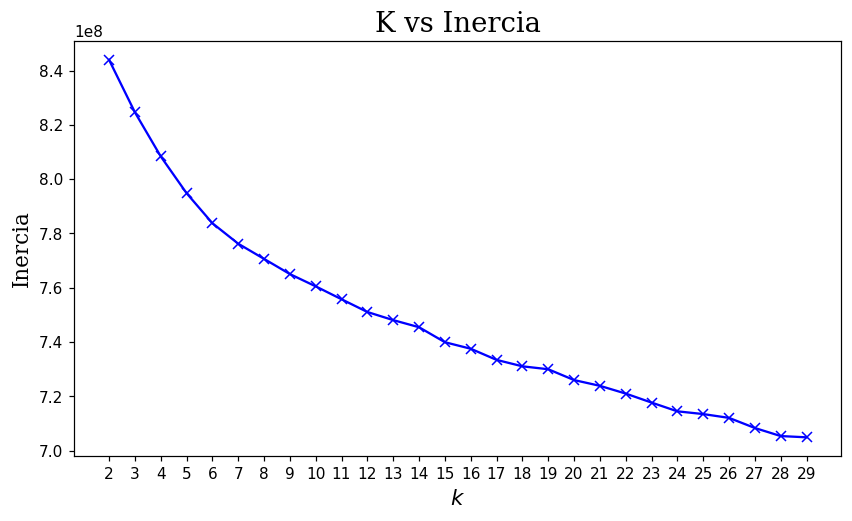

In [129]:
sum_of_squared_distances = []
K = range(2,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_trans)
    sum_of_squared_distances.append(km.inertia_)
    
plot_metric(K, sum_of_squared_distances, 'Inercia')

# ISODATA
---

Se implementa el algoritmo ISODATA tomado del notebook de clase

In [22]:
def initialize_parameters(parameters=None):
    """Auxiliar function to set default values to all the parameters not
    given a value by the user.

    """
    parameters = {} if not parameters else parameters

    def safe_pull_value(parameters, key, default):
        return parameters.get(key, default)

    # number of clusters desired
    K = safe_pull_value(parameters, 'K', 5)

    # maximum number of iterations
    I = safe_pull_value(parameters, 'I', 100)

    # maximum of number of pairs of clusters which can be merged
    P = safe_pull_value(parameters, 'P', 4)

    # threshold value for  minimum number of samples in each cluster
    # (discarding clusters)
    THETA_M = safe_pull_value(parameters, 'THETA_M', 10)

    # threshold value for standard deviation (for split)
    THETA_S = safe_pull_value(parameters, 'THETA_S', 1)
    # threshold value for pairwise distances (for merge)
    THETA_C = safe_pull_value(parameters, 'THETA_C', 20)

    # percentage of change in clusters between each iteration
    #(to stop algorithm)
    THETA_O = 0.05

    #can use any of both fixed or random
    # number of starting clusters
    #k = np.random.randint(1, K)
    k = safe_pull_value(parameters, 'k', K)

    ret = locals()
    ret.pop('safe_pull_value')
    ret.pop('parameters')
    globals().update(ret)


def quit_low_change_in_clusters(centers, last_centers, iter):
    """Stop algorithm by low change in the clusters values between each
    iteration.

    :returns: True if should stop, otherwise False.

    """
    quit = False
    if centers.shape == last_centers.shape:
        thresholds = np.abs((centers - last_centers) / (last_centers + 1))

        if np.all(thresholds <= THETA_O):  # percent of change in [0:1]
            quit = True
#            print "Isodata(info): Stopped by low threshold at the centers."
#            print "Iteration step: %s" % iter

    return quit


def merge_clusters(img_class_flat, centers, clusters_list):
    """
    Merge by pair of clusters in 'below_threshold' to form new clusters.
    """
    pair_dists = compute_pairwise_distances(centers)

    first_p_elements = pair_dists[:P]

    below_threshold = [(c1, c2) for d, (c1, c2) in first_p_elements
                                if d < THETA_C]

    if below_threshold:
        k = centers.size
        count_per_cluster = np.zeros(k)
        to_add = np.array([])  # new clusters to add
        to_delete = np.array([])  # clusters to delete

        for cluster in range(0, k):
            result = np.where(img_class_flat == clusters_list[cluster])
            indices = result[0]
            count_per_cluster[cluster] = indices.size

        for c1, c2 in below_threshold:
            c1_count = float(count_per_cluster[c1]) + 1
            c2_count = float(count_per_cluster[c2])
            factor = 1.0 / (c1_count + c2_count)
            weight_c1 = c1_count * centers[c1]
            weight_c2 = c2_count * centers[c2]

            value = round(factor * (weight_c1 + weight_c2))

            to_add = np.append(to_add, value)
            to_delete = np.append(to_delete, [c1, c2])

        #delete old clusters and their indices from the availables array
        centers = np.delete(centers, to_delete)
        clusters_list = np.delete(clusters_list, to_delete)

        #generate new indices for the new clusters
        #starting from the max index 'to_add.size' times
        start = int(clusters_list.max())
        end = to_add.size + start

        centers = np.append(centers, to_add)
        clusters_list = np.append(clusters_list, xrange(start, end))

        centers, clusters_list = sort_arrays_by_first(centers, clusters_list)

    return centers, clusters_list


def compute_pairwise_distances(centers):
    """
    Compute the pairwise distances 'pair_dists', between every two clusters
    centers and returns them sorted.
    Returns:
           - a list with tuples, where every tuple has in it's first coord the
             distance between to clusters, and in the second coord has a tuple,
             with the numbers of the clusters measured.
             Output example:
                [(d1,(cluster_1,cluster_2)),
                 (d2,(cluster_3,cluster_4)),
                 ...
                 (dn, (cluster_n,cluster_n+1))]
    """
    pair_dists = []
    size = centers.size

    for i in range(0, size):
        for j in range(0, size):
            if i > j:
                d = np.abs(centers[i] - centers[j])
                pair_dists.append((d, (i, j)))

    #return it sorted on the first elem
    return sorted(pair_dists)


def split_clusters(img_flat, img_class_flat, centers, clusters_list):
    """
    Split clusters to form new clusters.
    """
    assert centers.size == clusters_list.size, \
        "ERROR: split() centers and clusters_list size are different"

    delta = 10
    k = centers.size
    count_per_cluster = np.zeros(k)
    stddev = np.array([])

    avg_dists_to_clusters = compute_avg_distance(img_flat, img_class_flat,
                                                 centers, clusters_list)
    d = compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                                 clusters_list)

    # compute all the standard deviation of the clusters
    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size
        value = ((img_flat[indices] - centers[cluster]) ** 2).sum()
        value /= count_per_cluster[cluster]
        value = np.sqrt(value)
        stddev = np.append(stddev, value)

    cluster = stddev.argmax()
    max_stddev = stddev[cluster]
    max_clusters_list = int(clusters_list.max())

    if max_stddev > THETA_S:
        if avg_dists_to_clusters[cluster] >= d:
            if count_per_cluster[cluster] > (2.0 * THETA_M):
                old_cluster = centers[cluster]
                new_cluster_1 = old_cluster + delta
                new_cluster_2 = old_cluster - delta

                centers = np.delete(centers, cluster)
                clusters_list = np.delete(clusters_list, cluster)

                centers = np.append(centers, [new_cluster_1, new_cluster_2])
                clusters_list = np.append(clusters_list, [max_clusters_list,
                                          (max_clusters_list + 1)])

                centers, clusters_list = sort_arrays_by_first(centers,
                                                              clusters_list)

                assert centers.size == clusters_list.size, \
                   "ERROR: split() centers and clusters_list size are different"

    return centers, clusters_list


def compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                             clusters_list):
    """
    Computes the overall distance of the samples from their respective cluster
    centers.
    """
    k = avg_dists_to_clusters.size
    total = img_class_flat.size
    count_per_cluster = np.zeros(k)

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size

    d = ((count_per_cluster / total) * avg_dists_to_clusters).sum()

    return d


def compute_avg_distance(img_flat, img_class_flat, centers, clusters_list):
    """
    Computes all the average distances to the center in each cluster.
    """
    k = centers.size
    avg_dists_to_clusters = np.array([])

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]

        total_per_cluster = indices.size + 1
        sum_per_cluster = (np.abs(img_flat[indices] - centers[cluster])).sum()

        dj = (sum_per_cluster / float(total_per_cluster))

        avg_dists_to_clusters = np.append(avg_dists_to_clusters, dj)

    return avg_dists_to_clusters


def discard_clusters(img_class_flat, centers, clusters_list):
    """
    Discard clusters with fewer than THETA_M.
    """
    k = centers.shape[0]
    to_delete = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        total_per_cluster = indices.size
        if total_per_cluster <= THETA_M:
            to_delete = np.append(to_delete, cluster)

    if to_delete.size:
        new_centers = np.delete(centers, to_delete)
        new_clusters_list = np.delete(clusters_list, to_delete)
    else:
        new_centers = centers
        new_clusters_list = clusters_list

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

#        shape_bef = centers.shape[0]
#        shape_aft = new_centers.shape[0]
#        print "Isodata(info): Discarded %s clusters." % (shape_bef - shape_aft)

#        if to_delete.size:
#            print "Clusters discarded %s" % to_delete

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def update_clusters(img_flat, img_class_flat, centers, clusters_list):
    """ Update clusters. """
    k = centers.shape[0]
    new_centers = np.array([])
    new_clusters_list = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        #get whole cluster
        cluster_values = img_flat[indices]
        #sum and count the values
        sum_per_cluster = cluster_values.sum()
        total_per_cluster = (cluster_values.size) + 1
        #compute the new center of the cluster
        new_cluster = sum_per_cluster / total_per_cluster

        new_centers = np.append(new_centers, new_cluster)
        new_clusters_list = np.append(new_clusters_list, cluster)

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def initial_clusters(img_flat, k, method="linspace"):
    """
    Define initial clusters centers as startup.
    By default, the method is "linspace". Other method available is "random".
    """
    methods_availables = ["linspace", "random"]

    assert method in methods_availables, "ERROR: method %s is no valid." \
                                         "Methods availables %s" \
                                         % (method, methods_availables)
    if method == "linspace":
        max, min = img_flat.max(), img_flat.min()
        centers = np.linspace(min, max, k)
    elif method == "random":
        start, end = 0, img_flat.size
        indices = np.random.randint(start, end, k)
        centers = img_flat.take(indices)

    return centers


def sort_arrays_by_first(centers, clusters_list):
    """
    Sort the array 'centers' and the with indices of the sorted centers
    order the array 'clusters_list'.
    Example: centers=[22, 33, 0, 11] and cluster_list=[7,6,5,4]
    returns  (array([ 0, 11, 22, 33]), array([5, 4, 7, 6]))
    """
    assert centers.size == clusters_list.size, \
    "ERROR: sort_arrays_by_first centers and clusters_list size are not equal"

    indices = np.argsort(centers)

    sorted_centers = centers[indices]
    sorted_clusters_list = clusters_list[indices]

    return sorted_centers, sorted_clusters_list


def isodata_classification(img, parameters=None):
    """
    Classify a numpy 'img' using Isodata algorithm.
    Parameters: a dictionary with the following keys.
            - img: an input numpy array that contains the image to classify.
            - parameters: a dictionary with the initial values.
              If 'parameters' are not specified, the algorithm uses the default
              ones.
                  + number of clusters desired.
                    K = 15
                  + max number of iterations.
                    I = 100
                  + max number of pairs of clusters which can be ,erged.
                    P = 2
                  + threshold value for min number in each cluster.
                    THETA_M = 10
                  + threshold value for standard deviation (for split).
                    THETA_S = 0.1
                  + threshold value for pairwise distances (for merge).
                    THETA_C = 2
                  + threshold change in the clusters between each iter.
                    THETA_O = 0.01
        Note: if some(or all) parameters are nos providen, default values
              will be used.
    Returns:
            - img_class: a numpy array with the classification.
    """
    global K, I, P, THETA_M, THETA_S, THEHTA_C, THETA_O, k
    initialize_parameters(parameters)

    N, M = img.shape  # for reshaping at the end
    img_flat = img.flatten()
    clusters_list = np.arange(k)  # number of clusters availables

    print ("Isodata(info): Starting algorithm with %s classes" % k)
    centers = initial_clusters(img_flat, k, "linspace")

    for iter in range(0, I):
#        print "Isodata(info): Iteration:%s Num Clusters:%s" % (iter, k)
        last_centers = centers.copy()
        # assing each of the samples to the closest cluster center
        img_class_flat, dists = vq.vq(img_flat, centers)

        centers, clusters_list = discard_clusters(img_class_flat,
                                                  centers, clusters_list)
        centers, clusters_list = update_clusters(img_flat,
                                                 img_class_flat,
                                                 centers, clusters_list)
        k = centers.size

        if k <= (K / 2.0):  # too few clusters => split clusters
            centers, clusters_list = split_clusters(img_flat, img_class_flat,
                                                    centers, clusters_list)

        elif k > (K * 2.0):  # too many clusters => merge clusters
            centers, clusters_list = merge_clusters(img_class_flat, centers,
                                                    clusters_list)
        else:  # nor split or merge are needed
            pass

        k = centers.size
###############################################################################
        if quit_low_change_in_clusters(centers, last_centers, iter):
            break

#        take_snapshot(img_class_flat.reshape(N, M), iteration_step=iter)
###############################################################################
    print ("Isodata(info): Finished with %s classes" % k)
    print ("Isodata(info): Number of Iterations: %s" % (iter + 1))

    return img_class_flat.reshape(N, M)




def isodata_classification_DATA(data, parameters=None):
    """
    Classify a numpy 'data array' using Isodata algorithm.
    Parameters: a dictionary with the following keys.
            - img: an input numpy array that contains the image to classify.
            - parameters: a dictionary with the initial values.
              If 'parameters' are not specified, the algorithm uses the default
              ones.
                  + number of clusters desired.
                    K = 15
                  + max number of iterations.
                    I = 100
                  + max number of pairs of clusters which can be ,erged.
                    P = 2
                  + threshold value for min number in each cluster.
                    THETA_M = 10
                  + threshold value for standard deviation (for split).
                    THETA_S = 0.1
                  + threshold value for pairwise distances (for merge).
                    THETA_C = 2
                  + threshold change in the clusters between each iter.
                    THETA_O = 0.01
        Note: if some(or all) parameters are nos providen, default values
              will be used.
    Returns:
            - img_class: a numpy array with the classification.
    """
    global K, I, P, THETA_M, THETA_S, THEHTA_C, THETA_O, k
    initialize_parameters(parameters)

    #N, M = img.shape  # for reshaping at the end
    data_flat = data.flatten()
    clusters_list = np.arange(k)  # number of clusters availables

    print ("Isodata(info): Starting algorithm with %s classes" % k)
    centers = initial_clusters(data_flat, k, "linspace")

    for iter in range(0, I):
#        print "Isodata(info): Iteration:%s Num Clusters:%s" % (iter, k)
        last_centers = centers.copy()
        # assing each of the samples to the closest cluster center
        data_class_flat, dists = vq.vq(data_flat, centers)

        centers, clusters_list = discard_clusters(data_class_flat,
                                                  centers, clusters_list)
        centers, clusters_list = update_clusters(data_flat,
                                                 data_class_flat,
                                                 centers, clusters_list)
        k = centers.size

        if k <= (K / 2.0):  # too few clusters => split clusters
            centers, clusters_list = split_clusters(data_flat, data_class_flat,
                                                    centers, clusters_list)

        elif k > (K * 2.0):  # too many clusters => merge clusters
            centers, clusters_list = merge_clusters(data_class_flat, centers,
                                                    clusters_list)
        else:  # nor split or merge are needed
            pass

        k = centers.size
###############################################################################
        if quit_low_change_in_clusters(centers, last_centers, iter):
            break

#        take_snapshot(img_class_flat.reshape(N, M), iteration_step=iter)
###############################################################################
    print ("Isodata(info): Finished with %s classes" % k)
    print ("Isodata(info): Number of Iterations: %s" % (iter + 1))

    #return img_class_flat.reshape(N, M)
    return data_class_flat


In [23]:
cluster_n = 2
K = 2
params = {"K": K, "I" : 100, "P" : 4, "THETA_M" : 10, "THETA_S" : 0.1,
          "THETA_C" : 2, "THETA_O" : 0.01}
class_data = isodata_classification_DATA(X_trans, parameters=params)
print (class_data)
print (class_data.shape)

Isodata(info): Starting algorithm with 2 classes
Isodata(info): Finished with 2 classes
Isodata(info): Number of Iterations: 2
[0 0 0 ... 0 0 0]
(7769400,)


# Distancias encadenas
---

Se calcula la matriz de distancias entre todos los vectores

In [132]:
distances = pdist(X_trans, metric='euclidean')
dist_matrix = squareform(distances)
dist_matrix

array([[  0.        , 577.70371693, 574.68525114, ..., 615.72355571,
        543.95100105, 601.95409245],
       [577.70371693,   0.        , 520.51191176, ..., 550.84257222,
        594.20997644, 555.6042858 ],
       [574.68525114, 520.51191176,   0.        , ..., 612.46187674,
        605.83564936, 584.40657188],
       ...,
       [615.72355571, 550.84257222, 612.46187674, ...,   0.        ,
        598.31813626, 568.2060538 ],
       [543.95100105, 594.20997644, 605.83564936, ..., 598.31813626,
          0.        , 582.64547895],
       [601.95409245, 555.6042858 , 584.40657188, ..., 568.2060538 ,
        582.64547895,   0.        ]])

Plot de la matriz

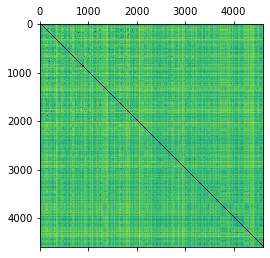

In [133]:
plt.matshow(dist_matrix)

Se implementa el algoritmo

In [134]:
def chain_distances(dist_matrix):
    # Inicia desde el primer vector
    length = dist_matrix.shape[0]
    index = [0]
    distances = []
    new_index = 0
    prev_index = 0
    # Se recorren todos los vectores
    for i in range(length):
        for j in range(length-1):
            new_index = np.argpartition(dist_matrix[prev_index], j+1)[j+1]
            # Si el vector más cercano ya fue utilizado anteriormente, se busca el siguiente vector más cercano que no haya sido utilizado.
            if new_index not in index:
                index.append(new_index)
                distances.append(dist_matrix[prev_index][new_index])
                prev_index = new_index
                break
                
    return distances, index
dis, ind = chain_distances(dist_matrix)

Plot de las distancias

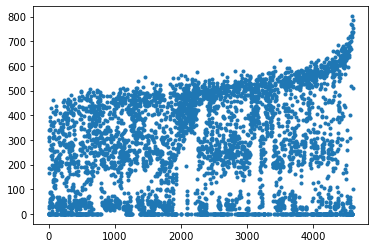

In [135]:
plt.plot(dis, ".")

Se observa que no hay clusters facilmente separables, en este caso este algoritmo es inviable.

Número de clusters para valores mayores a 550

In [136]:
np.where(np.array(dis)> 550)[0].shape[0]

338

# Min-Max
---

In [157]:
import itertools

stuff = [1, 2, 3]
for subset in itertools.combinations(stuff, 2):
    print(subset)
    

(1, 2)
(1, 3)
(2, 3)


In [191]:
def minmax(dist_matrix):
    length = dist_matrix.shape[0]
    vectors = [0]
    vectors.append(dist_matrix[0].argmax())
    temp_matrix = np.matrix([dist_matrix[0], dist_matrix[vectors[1]]])
    
    while True:
        min_vec = temp_matrix.min(axis=0)[0]
        min_index = np.argmax(min_vec)
        mean = 0
        for subset in itertools.combinations(vectors, 2):
            mean += dist_matrix[subset[0]][subset[1]]
        mean = mean/len(vectors)
        if not(min_vec[0, min_index] > mean):
            n_clusters = len(vectors)
            return vectors, n_clusters
        vectors.append(min_index)
        temp_matrix = np.vstack([temp_matrix, dist_matrix[min_index]]) 

De esta forma los "centroides" son los vectores 0, 492 y 4102

In [192]:
minmax(dist_matrix)

([0, 492, 4102], 3)

# Conclusiones
---

* Se observó que para esta aplicación clustering no es suficiente para clasificar correctamente los datos.
* En esta aplicación, cada algoritmo muestra un cantidad diferente de clusters.